In [1]:
!gdown 1izisGKP4LPYEHfGeBtnYipFfevqVj1dv

Downloading...
From: https://drive.google.com/uc?id=1izisGKP4LPYEHfGeBtnYipFfevqVj1dv
To: /content/news_dataset (1).json
100% 1.32M/1.32M [00:00<00:00, 181MB/s]


In [3]:
import pandas as pd

#read the dataset with name "Fake_Real_Data.csv" and store it in a variable df
df = pd.read_json("/content/news_dataset (1).json")

#print the shape of dataframe
print(df.shape)

#print top 5 rows
df.head(5)

(7500, 2)


,text,category
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS
3,This Richard Sherman Interception Literally Sh...,SPORTS
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS


In [ ]:
!python -m spacy download en_core_web_lg
import spacy
nlp = spacy.load("en_core_web_lg")

In [5]:
df.category.value_counts()

CRIME       2500
SPORTS      2500
BUSINESS    2500
Name: category, dtype: int64

**Dataset is Balanced**

In [7]:
#Add the new column which gives a unique number to each of these labels 
df['label_num'] = df['category'].map({'CRIME' : 0, 'SPORTS': 1,'BUSINESS':2})

#check the results with top 5 rows
df.head(5)

,text,category,label_num
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1
3,This Richard Sherman Interception Literally Sh...,SPORTS,1
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2


# Preprocess the text

In [8]:
#use this utility function to preprocess the text
#1. Remove the stop words
#2. Convert to base form using lemmatisation

def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    return ' '.join(filtered_tokens)

In [9]:
df['preprocessed_text']=df.text.apply(preprocess)

In [10]:
df.head()

,text,category,label_num,preprocessed_text
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0,Larry Nassar blame victim say victimize newly ...
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0,woman Beats Cancer die fall horse
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1,vegas taxpayer spend Record $ 750 million New ...
3,This Richard Sherman Interception Literally Sh...,SPORTS,1,Richard Sherman Interception literally shake W...
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2,7 thing totally kill Weed Legalization Buzz


# Get the spacy embeddings for each preprocessed text

In [11]:
df['vector']=df.preprocessed_text.apply(lambda x:nlp(x).vector)

# Train-Test splitting

In [15]:
df.head()

,text,category,label_num,preprocessed_text,vector
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0,Larry Nassar blame victim say victimize newly ...,"[-0.5585511, -0.29323253, -0.9253956, 0.189389..."
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0,woman Beats Cancer die fall horse,"[-0.73039824, -0.43196002, -1.2930516, -1.0628..."
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1,vegas taxpayer spend Record $ 750 million New ...,"[-1.9413117, 0.121578515, -3.2996283, 1.511650..."
3,This Richard Sherman Interception Literally Sh...,SPORTS,1,Richard Sherman Interception literally shake W...,"[-1.4702771, -0.685319, 0.57398, -0.31135806, ..."
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2,7 thing totally kill Weed Legalization Buzz,"[-1.037173, -1.9495698, -1.7179357, 1.2975286,..."


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values,
    df.label_num,
    test_size=0.2,
    random_state=2022
)

In [20]:
import numpy as np

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [22]:
X_train_2d.shape

(6000, 300)

In [23]:
y_train.value_counts()

1    2021
0    2014
2    1965
Name: label_num, dtype: int64

## Attempt 1:

* use spacy glove embeddings for text vectorization.

* use Decision Tree as the classifier.

* print the classification report.

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [26]:
clf = DecisionTreeClassifier()

In [27]:
clf.fit(X_train_2d,y_train)

DecisionTreeClassifier()

In [28]:
y_pred=clf.predict(X_test_2d)

In [29]:
y_test[:5]

873     1
1082    2
2016    0
3322    2
4781    1
Name: label_num, dtype: int64

In [30]:
y_pred[:5]

array([0, 2, 0, 2, 1])

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       486
           1       0.71      0.72      0.71       479
           2       0.77      0.72      0.75       535

    accuracy                           0.74      1500
   macro avg       0.74      0.74      0.74      1500
weighted avg       0.74      0.74      0.74      1500




# Attempt 2:

* use spacy glove embeddings for text vectorization.
* use MultinomialNB as the classifier after applying the MinMaxscaler.
* print the classification report

In [32]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

In [33]:
clf = MultinomialNB()

In [35]:
scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)

In [36]:
clf.fit(scaled_train_embed,y_train)

MultinomialNB()

In [38]:
y_pred=clf.predict(scaled_test_embed)

In [39]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       486
           1       0.82      0.84      0.83       479
           2       0.84      0.81      0.83       535

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500



# Attempt 3:

* use spacy glove embeddings for text vectorization.
* use KNeighborsClassifier as the classifier after applying the MinMaxscaler.
* print the classification report.

In [53]:
from  sklearn.neighbors import KNeighborsClassifier


In [54]:
clf= KNeighborsClassifier()

In [55]:
clf.fit(scaled_train_embed,y_train)

KNeighborsClassifier()

In [56]:
y_pred=clf.predict(scaled_test_embed)

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       486
           1       0.87      0.81      0.84       479
           2       0.90      0.82      0.86       535

    accuracy                           0.84      1500
   macro avg       0.85      0.84      0.84      1500
weighted avg       0.85      0.84      0.84      1500



# Attempt 4:

* use spacy glove embeddings for text vectorization.
* use RandomForestClassifier as the classifier after applying the MinMaxscaler.
* print the classification report.

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
clf=RandomForestClassifier()

In [60]:
clf.fit(scaled_train_embed,y_train)

RandomForestClassifier()

In [61]:
y_pred=clf.predict(scaled_test_embed)

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       486
           1       0.88      0.89      0.88       479
           2       0.91      0.88      0.89       535

    accuracy                           0.88      1500
   macro avg       0.88      0.88      0.88      1500
weighted avg       0.88      0.88      0.88      1500



# Attempt 5:

* use spacy glove embeddings for text vectorization.
* use GradientBoostingClassifier as the classifier after applying the * 
* MinMaxscaler.
* print the classification report.

In [63]:
from sklearn.ensemble import GradientBoostingClassifier

In [64]:
clf=GradientBoostingClassifier()

In [65]:
clf.fit(scaled_train_embed,y_train)

GradientBoostingClassifier()

In [66]:
y_pred=clf.predict(scaled_test_embed)

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88       486
           1       0.89      0.89      0.89       479
           2       0.91      0.90      0.90       535

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500



# Confusion Matrix --(For our Best Model **GradientBoostingClassifier**)

Text(95.72222222222221, 0.5, 'Truth')

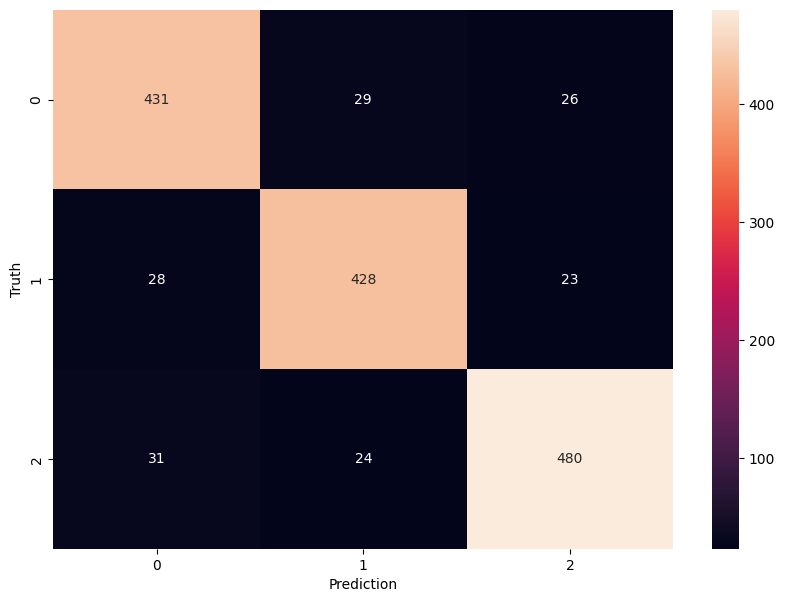

In [68]:
#finally print the confusion matrix for the best model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

link --> https://colab.research.google.com/drive/1T2Y6G_CCkYQ-WLg3XaZKXuOx-kqvUU9J?usp=sharing